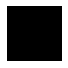

In [2]:
import matplotlib.pyplot as plt
import numpy as np
x = np.zeros((1,1)) * 255
plt.figure(figsize = (1,1))
plt.axis('off')
plt.imshow(x,  cmap='gray', vmin=0, vmax=255)
plt.show()

# An Introduction to Neural Networks
In this notebook, the goal is to understand the basics of implementing a fully connected neural network in python using the pytorch library. This is done by completing three steps: 
<ul>
  <li>Loading the MNIST data-set and preformatting the data. The MNIST data set consist out of a number of samples of handwirtten numbers, recorded on a 28x28 grid with values between 0 and 1 for each element.</li>
  <li>Constructing a deep and fully connected neural network based on some given hyperparameters. </li>
  <li>Training and validating this network on the loaded data-set. Here, we will vary some hyperparamters and investigate their influence on the final result.</li>
</ul>  

## Loading required Libraries
In a first step, we have to load the packages we want to uses. This includes the numpy package for preprocessing the data, the pytorch package (torch) for constructing and training the neural network, and the matplotlib package for visualizing the results. We also define a function that allows us the easy representation of any sample from the data-set.

In [3]:
# Load numpy library
import numpy as np
# Load pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# Load matplotlib library
import matplotlib.pyplot as plt


def plot_in_and_out(x, y_true, y_pred = np.array([None, None])):
    plt.figure(figsize = (5,5))
    plt.axis('off')
    plt.imshow(x,  cmap='gray', vmin=0, vmax=255)
    if (y_pred == None).any():
        plt.title('This figure is labelled as a {}.'.format(y_true))
    else:
        plt.title('This figure is labelled as a {}, \n while beeing classified as {} (probability: {:0.3f}).'.format(y_true, int(y_pred[0]), y_pred[1]))
    plt.show()

d:\Anaconda\envs\tf_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the data-set
After setting up our python file, we have to load the MNIST data set. This consists out of a training set and a testing set. 

In [4]:
import torchvision.datasets as datasets
# load the training set
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
# load the test set
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)


## Transform the data-set
After loading the dataset, we have to load transform it into a better form.
Currently, both data set consist out of a list of samples (60 000 training samples and 10 000 testing samples), each sample being a tuple of an image and an integer label. Our goal is to transform those into numpy arrays for input and label of training and testing set each:

In [5]:
# Set up empty numpy arrays:
x_train = mnist_trainset.data.numpy() # training input
y_train = mnist_trainset.targets.numpy() # training labels

x_test = mnist_testset.data.numpy() # testing input
y_test = mnist_testset.targets.numpy() # testing labels
    
# test if data loaded correctly
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

## Showing an example
We can show how one sample looks:

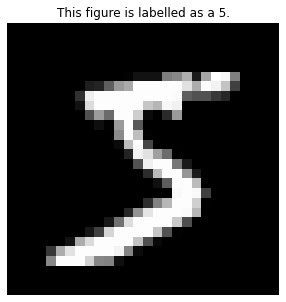

In [6]:
i_sample = 0
plot_in_and_out(x_train[i_sample], y_train[i_sample])

## Transforming the labels
The neural network will be constructed to have ten possible outputs, as there are ten possible digits (0,1,...,9). Consequently, the last layer of the network will have ten nodes. Each node here represents the probabilty of the input being the corresponding number. For example, the output [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] will correspond to the network being 100% sure that the input is an 0.

To train such a network, our labels of the training set therefore have to be transformed into a so-called one-hot encoding.

In [7]:
# set number of classes
num_classes = 10
# create array full of zeros
y_train_cat = np.zeros((len(y_train), num_classes))
# override specific entry in each row with a 1
y_train_cat[np.arange(len(y_train)), y_train] = 1

print('The one-hot encoding corresponding to label {}:'.format(y_train[i_sample]), y_train_cat[i_sample,:])

The one-hot encoding corresponding to label 5: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## Example: Constructing a neural network
The goal is now to create a dense neural netwrok which can classify a given number according to its input. <br>
Such an network consists out of three parts, which are the <span style="color: #ff8080">input layer</span>, the <span style="color: #8080ff">hidden layers</span> and the <span style="color: #80ff80">output layer</span>.

![An examplar structure of a feed-forward neural network](Neural_Network.png)


In pytorch, such networks are commonly constructed as a model class.
For a 3 layer dense neural network, where the input samples have the dimensionality of 28x28, and the hidden layer has 100 nueron, while the output layer has 10, it would be implemented in the following way:

In [8]:
class Neural_network(nn.Module): #inherit the nn.Module class for backpropagation and training functionalities
    # Build the layers of the network, and initializes the parameters
    def __init__(self): 
        super(Neural_network, self).__init__()
        self.fc1 = nn.Linear(784, 100, bias = True)  # fully connected layer from 784 to 100 dimensions
        self.fc2 = nn.Linear(100, 10, bias = True) # fully connected layer from 100 to 10 dimensions
    
    # Build the forward call 
    def forward(self, x): # x is the input of dimensionality n x 28 x 28
        x = torch.flatten(x, start_dim = 1) # x is reshaped into a n x 784 dimensional input 
        x = self.fc1(x) # apply the first fully connected layer, x now has shape n x 100
        x = F.relu(x) # We apply a ReLU activation to the hidden layer
        x = self.fc2(x) # We apply the second fully connected layer, x now has shape n x 10
        x = F.softmax(x, dim = -1) # We apply the softmax activation function
        return x

The softmax activation function takes an input x and transforms it into y so that the sum over y is equal to 1. To avoid any influence of the mean of x, one uses the fromula y = exp(x) / sum(exp(x)) 

The parts of the model, as well as their respective parameters, can then be displayed:

In [9]:
torch.manual_seed(0) # set random seed for variabl initialization
net = Neural_network()
print(net)
print('')
params = list(net.parameters())
print('Number of parameter arrays: ' + str(len(params)))
print('The shape of the parameter arrays:')
for param in params:
    print(param.shape)

Neural_network(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

Number of parameter arrays: 4
The shape of the parameter arrays:
torch.Size([100, 784])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


## Training the model
After writing the model class, we now can train the parameters of the model on a data-set. Here, we have to do a number of steps. 

### Defining a loss function:
The network is able to process an input, but to be able to learn, it has to be able to evaluate the input. This is the purpose of the loss function. Here, we will use the mean squared error: 

In [10]:
loss_func = nn.MSELoss()

The we also have to define an optimizer. This takes the gradients of loss function in regard to the parameters and then changes the parameters accordingly. Here, we use the Adam algorithm:

In [11]:
# optimizer = optim.SGD(net.parameters(), lr=0.001)
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))

Finally, we have to normalize the inputs:

In [12]:
x_train_norm = x_train.astype('float32')

x_mean = x_train_norm.mean(axis = 0, keepdims = True)
x_train_norm -= x_mean

x_std = (x_train_norm.std(axis = 0, keepdims = True) + 1e-8)
x_train_norm /= x_std

x_test_norm = (x_test.astype('float32') - x_mean)/x_std

Now we have to just iterate over a number of epochs and number of batches:

In [12]:
epochs = 100 # how many times do we want to go through the whole data set
batch_size = 200 # how many samples do we process before updating weights
batches = int(np.floor(len(y_train)/batch_size)) # how many batches are there when dividing the whole data set

net.train() # set network to training mode
Index = np.arange(len(y_train)) #Index, so we can randomly shuffle inputs and outputs

np.random.seed(0) # set random seed for shuffling

for epoch in range(1, epochs + 1):
    np.random.shuffle(Index) # shuffle indices, so we do not circle during optimization
    
    loss_epoch = 0
    
    for batch in range(batches):
        Index_batch = Index[batch * batch_size:(batch + 1) * batch_size]
        x_batch = torch.from_numpy(x_train_norm[Index_batch]) # Get respective input data and transform into torch tensor
        y_batch = torch.from_numpy(y_train_cat[Index_batch].astype('float32')) # Get respective output data and transform into torch tensor
        
        # delete gradients from optimizer (otherwise, gradients are cummulative summed up over all previous batches)
        optimizer.zero_grad()
        # predict the output for the given inputs (forward pass)
        y_batch_pred = net(x_batch)
        # calculate the loss of the predicted input (forward pass)
        loss = loss_func(y_batch_pred, y_batch)
        # get the gradients of the trainable paramters for the given loss (backward pass)
        loss.backward()
        # apply the gradients and change weights
        optimizer.step()
        
        loss_epoch += loss
    
    loss_epoch /= batches
    print('Loss for epoch {}/{}: {:0.4e}'.format(epoch,epochs, loss_epoch) )
        

Loss for epoch 1/100: 1.5230e-02
Loss for epoch 2/100: 6.2644e-03
Loss for epoch 3/100: 4.5620e-03
Loss for epoch 4/100: 3.5355e-03
Loss for epoch 5/100: 2.8777e-03
Loss for epoch 6/100: 2.3887e-03
Loss for epoch 7/100: 1.9574e-03
Loss for epoch 8/100: 1.6831e-03
Loss for epoch 9/100: 1.4493e-03
Loss for epoch 10/100: 1.2732e-03
Loss for epoch 11/100: 1.1353e-03
Loss for epoch 12/100: 1.0537e-03
Loss for epoch 13/100: 9.5033e-04
Loss for epoch 14/100: 8.4237e-04
Loss for epoch 15/100: 7.8661e-04
Loss for epoch 16/100: 7.2439e-04
Loss for epoch 17/100: 7.3040e-04
Loss for epoch 18/100: 7.4985e-04
Loss for epoch 19/100: 6.7398e-04
Loss for epoch 20/100: 5.8861e-04
Loss for epoch 21/100: 5.3843e-04
Loss for epoch 22/100: 6.0082e-04
Loss for epoch 23/100: 5.1422e-04
Loss for epoch 24/100: 5.1216e-04
Loss for epoch 25/100: 5.5640e-04
Loss for epoch 26/100: 5.9100e-04
Loss for epoch 27/100: 5.7405e-04
Loss for epoch 28/100: 4.4670e-04
Loss for epoch 29/100: 4.3791e-04
Loss for epoch 30/100: 

## Testing the model
Finally, the model has to be tested:

In [13]:
net.eval() # Set model inot evaluation mode
with torch.no_grad(): # Only build forwards graph => faster method
    y_test_pred = net(torch.from_numpy(x_test_norm))
y_test_pred = y_test_pred.detach().numpy()

To get a prediction, we now have to find the label with the highest probability:

In [14]:
y_pred = np.concatenate((y_test_pred.argmax(axis = 1)[:,np.newaxis],          # Get the number with the highest probability
                         y_test_pred.max(axis = 1)[:,np.newaxis]), axis = 1)  # Get the corresponding probability

We can now visualize the predictions:

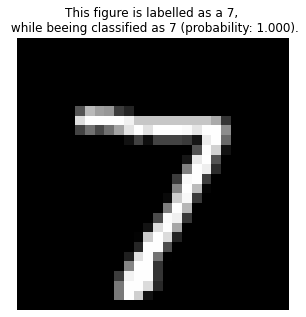

In [15]:
i_sample_test = 0
plot_in_and_out(x_test[i_sample_test], y_test[i_sample_test], y_pred[i_sample_test])

### Determine Accuracy
Finally, one can determine the accuracy of the model on the test set

In [16]:
accuracy = np.mean(y_test == y_pred[:,0])
print('The accuracy of the model on the test set is {:0.2f}%'.format(100*accuracy))

The accuracy of the model on the test set is 97.43%


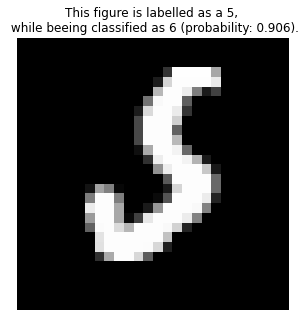

In [17]:
failures = np.where(y_test != y_pred[:,0])[0]

i_sample_failure = failures[-1]
plot_in_and_out(x_test[i_sample_failure], y_test[i_sample_failure], y_pred[i_sample_failure])

## Varying the hyperparamters
After seeing the example, we now have the goal of building a function which allows us to evaluate the performance for a certain implementation of a neural network, given a number of hyperparamters. The goal is to implement a neural network with two hidden layers, using relu activation in all but the last layers.
The following things are to be varied:
<ul>
  <li>The optimizer: Use Adam as well as SDG</li>
  <li>The batch size: Use 10, 100, 1000, 10000 </li>
  <li>The number of neuron in the second hidden layer: Use 10, 50, 100 </li>
</ul>  
Meanwhile, 100 epochs are to be used for training, and the first hidden layer should have 100 neurons.
<br>
The accuracy of the trained models on the test has to be calculated for a comparison.

In [17]:
# TODO:
# Implement a neural network with two hidden layers and use the ReLU activation function in all but the last layer.
class Neural_network(nn.Module): 
    def __init__(self, second_hidden_layer_size):
        super(Neural_network, self).__init__()
        self.fc1 = nn.Linear(784, 100, bias = True)  
        self.fc2 = nn.Linear(100, second_hidden_layer_size, bias = True) 
        self.fc3 = nn.Linear(second_hidden_layer_size, 10, bias = True) 
    
    def forward(self, x): 
        x = torch.flatten(x, start_dim = 1) 
        x = self.fc1(x) 
        x = F.relu(x) 
        x = self.fc2(x) 
        x = F.relu(x) 
        x = self.fc3(x) 
        x = F.softmax(x, dim = -1) 
        return x



In [33]:
import torch
print(torch.cuda.is_available())

True


In [34]:
# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ' + str(device))

# Set random seed for variable initialization
torch.manual_seed(0)
if device.type == 'cuda':
    torch.cuda.manual_seed(0)

# Initialize the neural network and move it to the GPU
net = Neural_network(50).to(device)
print(net)
print('')
params = list(net.parameters())
print('Number of parameter arrays: ' + str(len(params)))
print('The shape of the parameter arrays:')
for param in params:
    print(param.shape)

Device: cuda
Neural_network(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)

Number of parameter arrays: 6
The shape of the parameter arrays:
torch.Size([100, 784])
torch.Size([100])
torch.Size([50, 100])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [37]:
# The optimizer: Use Adam as well as SDG
#  The batch size: Use 10, 100, 1000, 10000 
#  The number of neuron in the second hidden layer: Use 10, 50, 100
from tqdm import tqdm

np.random.seed(0)

# Loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define batch sizes and second hidden layer neuron counts
batch_sizes = [10, 100, 1000, 10000]
hidden_layer_sizes = [10, 50, 100]
optimizers = ['Adam', 'SGD']
epochs = 100

for optimizer_type in optimizers:
    for batch_size in batch_sizes:
        for hidden_layer_size in hidden_layer_sizes:
            # Initialize the network with the current hidden layer size and move to device
            net = Neural_network(hidden_layer_size).to(device)

            # Select the optimizer: either Adam or SGD
            if optimizer_type == 'Adam':
                optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
            elif optimizer_type == 'SGD':
                optimizer = optim.SGD(net.parameters(), lr=0.001)

            batches = int(np.floor(len(y_train) / batch_size))  # Calculate number of batches
            
            print(f"Training with {optimizer_type}, batch size {batch_size}, and {hidden_layer_size} neurons in the second hidden layer.")
            
            net.train()  # Set the network to training mode
            Index = np.arange(len(y_train))  # Index for shuffling

            # Initialize the progress bar for epochs
            for epoch in tqdm(range(1, epochs + 1), desc=f"Epochs for {optimizer_type} | Batch size {batch_size} | Neurons {hidden_layer_size}"):
                np.random.shuffle(Index)  # Shuffle indices before each epoch
                loss_epoch = 0
                
                for batch in range(batches):
                    # Get the indices for this batch
                    Index_batch = Index[batch * batch_size:(batch + 1) * batch_size]
                    
                    # Convert numpy arrays to PyTorch tensors and move them to the device
                    x_batch = torch.from_numpy(x_train_norm[Index_batch]).float().to(device)
                    y_batch = torch.from_numpy(y_train_cat[Index_batch].astype('float32')).to(device)
                    
                    # Clear gradients from the optimizer
                    optimizer.zero_grad()
                    
                    # Forward pass: compute predicted y
                    y_batch_pred = net(x_batch)
                    
                    # Compute loss
                    loss = loss_func(y_batch_pred, y_batch)
                    
                    # Backward pass: compute gradient of the loss with respect to model parameters
                    loss.backward()
                    
                    # Update weights
                    optimizer.step()
                    
                    loss_epoch += loss.item()  # Accumulate loss for this epoch
                
                # Compute average loss for this epoch
                loss_epoch /= batches

            # After training, set the model in evaluation mode and compute accuracy on the test set
            net.eval()  # Set model to evaluation mode
            with torch.no_grad():  # Disable gradient computation for faster evaluation
                # Perform prediction on the test set
                y_test_pred = net(torch.from_numpy(x_test_norm).float().to(device))
                y_test_pred = y_test_pred.detach().cpu().numpy()  # Move predictions back to CPU and convert to numpy

            # Get predicted labels and corresponding probabilities
            y_pred = np.concatenate((y_test_pred.argmax(axis=1)[:, np.newaxis],  # Get the predicted class
                                     y_test_pred.max(axis=1)[:, np.newaxis]), axis=1)  # Get the corresponding probability

            # Compute accuracy by comparing predicted labels to true labels
            accuracy = np.mean(y_test == y_pred[:, 0])
            
            # Print the accuracy for this configuration
            print(f'The accuracy of the model on the test set with {optimizer_type}, batch size {batch_size}, and {hidden_layer_size} neurons is {100 * accuracy:.2f}%')

Training with Adam, batch size 10, and 10 neurons in the second hidden layer.


Epochs for Adam | Batch size 10 | Neurons 10: 100%|██████████| 100/100 [17:13<00:00, 10.33s/it]


The accuracy of the model on the test set with Adam, batch size 10, and 10 neurons is 95.48%
Training with Adam, batch size 10, and 50 neurons in the second hidden layer.


Epochs for Adam | Batch size 10 | Neurons 50: 100%|██████████| 100/100 [18:51<00:00, 11.31s/it]


The accuracy of the model on the test set with Adam, batch size 10, and 50 neurons is 95.73%
Training with Adam, batch size 10, and 100 neurons in the second hidden layer.


Epochs for Adam | Batch size 10 | Neurons 100: 100%|██████████| 100/100 [19:35<00:00, 11.76s/it]


The accuracy of the model on the test set with Adam, batch size 10, and 100 neurons is 94.79%
Training with Adam, batch size 100, and 10 neurons in the second hidden layer.


Epochs for Adam | Batch size 100 | Neurons 10: 100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


The accuracy of the model on the test set with Adam, batch size 100, and 10 neurons is 97.12%
Training with Adam, batch size 100, and 50 neurons in the second hidden layer.


Epochs for Adam | Batch size 100 | Neurons 50: 100%|██████████| 100/100 [02:05<00:00,  1.26s/it]


The accuracy of the model on the test set with Adam, batch size 100, and 50 neurons is 97.20%
Training with Adam, batch size 100, and 100 neurons in the second hidden layer.


Epochs for Adam | Batch size 100 | Neurons 100: 100%|██████████| 100/100 [02:06<00:00,  1.27s/it]


The accuracy of the model on the test set with Adam, batch size 100, and 100 neurons is 97.08%
Training with Adam, batch size 1000, and 10 neurons in the second hidden layer.


Epochs for Adam | Batch size 1000 | Neurons 10: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s]


The accuracy of the model on the test set with Adam, batch size 1000, and 10 neurons is 97.14%
Training with Adam, batch size 1000, and 50 neurons in the second hidden layer.


Epochs for Adam | Batch size 1000 | Neurons 50: 100%|██████████| 100/100 [00:24<00:00,  4.09it/s]


The accuracy of the model on the test set with Adam, batch size 1000, and 50 neurons is 97.24%
Training with Adam, batch size 1000, and 100 neurons in the second hidden layer.


Epochs for Adam | Batch size 1000 | Neurons 100: 100%|██████████| 100/100 [00:24<00:00,  4.06it/s]


The accuracy of the model on the test set with Adam, batch size 1000, and 100 neurons is 96.99%
Training with Adam, batch size 10000, and 10 neurons in the second hidden layer.


Epochs for Adam | Batch size 10000 | Neurons 10: 100%|██████████| 100/100 [00:10<00:00,  9.75it/s]


The accuracy of the model on the test set with Adam, batch size 10000, and 10 neurons is 96.30%
Training with Adam, batch size 10000, and 50 neurons in the second hidden layer.


Epochs for Adam | Batch size 10000 | Neurons 50: 100%|██████████| 100/100 [00:10<00:00,  9.74it/s]


The accuracy of the model on the test set with Adam, batch size 10000, and 50 neurons is 96.63%
Training with Adam, batch size 10000, and 100 neurons in the second hidden layer.


Epochs for Adam | Batch size 10000 | Neurons 100: 100%|██████████| 100/100 [00:10<00:00,  9.70it/s]


The accuracy of the model on the test set with Adam, batch size 10000, and 100 neurons is 96.89%
Training with SGD, batch size 10, and 10 neurons in the second hidden layer.


Epochs for SGD | Batch size 10 | Neurons 10: 100%|██████████| 100/100 [13:36<00:00,  8.16s/it]


The accuracy of the model on the test set with SGD, batch size 10, and 10 neurons is 96.08%
Training with SGD, batch size 10, and 50 neurons in the second hidden layer.


Epochs for SGD | Batch size 10 | Neurons 50: 100%|██████████| 100/100 [13:42<00:00,  8.23s/it]


The accuracy of the model on the test set with SGD, batch size 10, and 50 neurons is 96.32%
Training with SGD, batch size 10, and 100 neurons in the second hidden layer.


Epochs for SGD | Batch size 10 | Neurons 100: 100%|██████████| 100/100 [14:53<00:00,  8.93s/it]


The accuracy of the model on the test set with SGD, batch size 10, and 100 neurons is 96.04%
Training with SGD, batch size 100, and 10 neurons in the second hidden layer.


Epochs for SGD | Batch size 100 | Neurons 10: 100%|██████████| 100/100 [01:41<00:00,  1.02s/it]


The accuracy of the model on the test set with SGD, batch size 100, and 10 neurons is 84.94%
Training with SGD, batch size 100, and 50 neurons in the second hidden layer.


Epochs for SGD | Batch size 100 | Neurons 50: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


The accuracy of the model on the test set with SGD, batch size 100, and 50 neurons is 84.74%
Training with SGD, batch size 100, and 100 neurons in the second hidden layer.


Epochs for SGD | Batch size 100 | Neurons 100: 100%|██████████| 100/100 [01:40<00:00,  1.00s/it]


The accuracy of the model on the test set with SGD, batch size 100, and 100 neurons is 83.85%
Training with SGD, batch size 1000, and 10 neurons in the second hidden layer.


Epochs for SGD | Batch size 1000 | Neurons 10: 100%|██████████| 100/100 [00:21<00:00,  4.56it/s]


The accuracy of the model on the test set with SGD, batch size 1000, and 10 neurons is 16.70%
Training with SGD, batch size 1000, and 50 neurons in the second hidden layer.


Epochs for SGD | Batch size 1000 | Neurons 50: 100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


The accuracy of the model on the test set with SGD, batch size 1000, and 50 neurons is 13.83%
Training with SGD, batch size 1000, and 100 neurons in the second hidden layer.


Epochs for SGD | Batch size 1000 | Neurons 100: 100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


The accuracy of the model on the test set with SGD, batch size 1000, and 100 neurons is 34.84%
Training with SGD, batch size 10000, and 10 neurons in the second hidden layer.


Epochs for SGD | Batch size 10000 | Neurons 10: 100%|██████████| 100/100 [00:10<00:00,  9.61it/s]


The accuracy of the model on the test set with SGD, batch size 10000, and 10 neurons is 8.57%
Training with SGD, batch size 10000, and 50 neurons in the second hidden layer.


Epochs for SGD | Batch size 10000 | Neurons 50: 100%|██████████| 100/100 [00:10<00:00,  9.56it/s]


The accuracy of the model on the test set with SGD, batch size 10000, and 50 neurons is 11.86%
Training with SGD, batch size 10000, and 100 neurons in the second hidden layer.


Epochs for SGD | Batch size 10000 | Neurons 100: 100%|██████████| 100/100 [00:10<00:00,  9.31it/s]

The accuracy of the model on the test set with SGD, batch size 10000, and 100 neurons is 10.31%
